In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

from encoder import *
from AttnDecoder import * 
from seq2seq_transformer import *

from build_dataset import *
from inference import *
from tqdm import tqdm

from greedy_search import generate_question

[nltk_data] Downloading package wordnet to /home/tb2817/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/tb2817/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 1. Load dataloaders 

In [3]:
# set whether or not model is pretrained
model_pretrained = True

In [4]:
# load data 
main_data_path = "data/processed"

train_file_path = {
    'source': f"{main_data_path}/src-train.txt",
    'target': f"{main_data_path}/tgt-train.txt"
}

test_file_path = {
    'source': f"{main_data_path}/src-test.txt",
    'target': f"{main_data_path}/tgt-test.txt"
}

dev_file_path = {
    'source': f"{main_data_path}/src-dev.txt",
    'target': f"{main_data_path}/tgt-dev.txt"
}

# build vocab with train data only 
vocab = build_train_vocab(train_file_path)

# build datasets for all train, test, dev
datasets = {
    'train': QAPair(train_file_path, vocab),
    'test': QAPair(test_file_path, vocab),
    'dev': QAPair(dev_file_path, vocab),
}

# build dataloaders
batch_size = 64
dataloaders = {}
for split, dataset in datasets.items():
    dataloaders[split] = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=partial(pad_collate_fn, pad_token=dataset.pad_idx)
    )

# 2. Load parsed GloVe embeddings

In [5]:
embed_size = 300
pretrained_vectors = {
    'enc': torch.load(f'embeddings/encoder_emb_{embed_size}.pt').float(),
    'dec': torch.load(f'embeddings/decoder_emb_{embed_size}.pt').float()
}

# input_size = len(train_dataset.answer_vocab) 
output_size = len(vocab['target'])

# 3. Train loop

## 3.1 Define train and eval steps

In [5]:
def train_step(batch, model, optimizer, criterion, device):
    model.train()
    source = batch.source_vecs.to(device) 
    source_len = batch.source_lens.to(device)
    target = batch.target_vecs.to(device)
    target_len = batch.target_lens.to(device) 

    target_input = target[:, :-1]

    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(source, target_input)

    logits = model(source, target_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
    
    optimizer.zero_grad()

    target_out = target[:, 1:]
    # print(f'dec_log_probs {dec_log_probs.shape}')
    # print(f'target_out {target_out.shape}')
    loss = criterion(logits.transpose(1, 2), target_out)
    loss.backward()
    # clip gradients
    # nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0, norm_type=2)
    
    optimizer.step()

    # return the attention scores at the last time step
    return loss.item(), logits

def eval_step(batch, model, criterion, device):
    model.eval()
    source = batch.source_vecs.to(device) 
    inputs_len = batch.source_lens.to(device)
    target = batch.target_vecs.to(device)
    target_len = batch.target_lens.to(device) 

    target_input = target[:, :-1]

    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(source, target_input)

    logits = model(source, target_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
    
    target_out = target[:, 1:]

    # scores = s2s_output.view(-1, s2s_output.size(-1))
    
    loss = criterion(logits.transpose(1, 2), target_out)

    # return the attention scores at the last time step
    return loss.item(), logits
    

## 3.2 Run train loop

In [6]:
# TRAIN LOOP 
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
EMBED_SIZE = 300
NHEAD = 10

if not model_pretrained:
    # initial learning rate
    lr = 0.01
    # initialize the model, optimizer, and criterion
    seq2seq = Seq2SeqTransformer(
        NUM_ENCODER_LAYERS,
        NUM_DECODER_LAYERS,
        EMBED_SIZE,
        NHEAD,
        pretrained_vectors, 
        tgt_vocab_size=len(vocab['target'])
    )
    optimizer = torch.optim.SGD(seq2seq.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=datasets['train'].pad_idx)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    seq2seq.to(device)

    plot_cache = {}
    plot_cache['train'] = []
    plot_cache['dev'] = []

    # halve lr at epoch 8
    scheduler = StepLR(optimizer, step_size=20, gamma=0.5) 

    NUM_EPOCHS = 15
    for epoch in tqdm(range(NUM_EPOCHS)):    
        # train 
        train_losses = []
        for i, data in tqdm(enumerate(dataloaders['train']), leave=False):
            curr_loss, dec_log_probs = train_step(data, seq2seq, optimizer, criterion, device)

            train_losses.append(curr_loss)

        avg_train_loss = np.mean(train_losses)
        print(f'Train loss after epoch {epoch+1} = {avg_train_loss}')

        # eval 
        test_losses = []
        with torch.no_grad():
            for i, data in tqdm(enumerate(dataloaders['dev']), leave=False):
                curr_loss, dec_log_probs = eval_step(data, seq2seq, criterion, device)

                test_losses.append(curr_loss)

            avg_test_loss = np.mean(test_losses)
            print(f'Dev loss after epoch {epoch+1} = {avg_test_loss}')

        plot_cache['train'].append(avg_train_loss)
        plot_cache['dev'].append(avg_test_loss)

        scheduler.step()

    # save the model state
    torch.save({'state_dict': seq2seq.state_dict(), 'plot_cache': plot_cache}, 'trained_transformer_statedict.pt')
else:
    # reload the model
    seq2seq = Seq2SeqTransformer(
        NUM_ENCODER_LAYERS,
        NUM_DECODER_LAYERS,
        EMBED_SIZE,
        NHEAD,
        pretrained_vectors, 
        tgt_vocab_size=len(vocab['target'])
    )
    criterion = nn.CrossEntropyLoss(ignore_index=datasets['train'].pad_idx)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    seq2seq.to(device)

    checkpoint = torch.load('trained_transformer_statedict.pt')
    seq2seq.load_state_dict(checkpoint['state_dict'])
    plot_cache = checkpoint['plot_cache']

In [16]:
# run inference on the test set
test_losses = []
all_best_attn_labels = []
all_preds_list = []
all_labels_list = []
raw_labels_list = []
raw_source_list = []
all_cleaned_preds_list = []
all_bleu_1 = []
all_bleu_2 = []
all_bleu_3 = []
all_bleu_4 = []
all_meteor = []
all_rouge_l = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dataloaders['test']), leave=False):
        # run evaluation on the test set
        curr_loss, dec_log_probs = eval_step(data, seq2seq, criterion, device)
        test_losses.append(curr_loss)

        # run vanilla inference on the test set
        preds_list, labels_list = vanilla_inference(dec_log_probs, data.target_vecs, vocab['target'])

        # evaluate the predictions with the metrics
        bleu_1, bleu_2, bleu_3, bleu_4, meteor, rouge_l = eval_metrics(preds_list, labels_list) # meteor, rouge_l
        all_bleu_1.append(bleu_1)
        all_bleu_2.append(bleu_2)
        all_bleu_3.append(bleu_3)
        all_bleu_4.append(bleu_4)
        all_meteor.append(meteor)
        all_rouge_l.append(rouge_l)

        all_preds_list.append(preds_list)
        all_labels_list.append(labels_list)
        # all_cleaned_preds_list.append(cleaned_preds_list)
        raw_labels_list.append(data.target_data)
        raw_source_list.append(data.source_data)

    avg_test_loss = np.mean(test_losses)
    avg_bleu_1 = np.mean(all_bleu_1)
    avg_bleu_2 = np.mean(all_bleu_2)
    avg_bleu_3 = np.mean(all_bleu_3)
    avg_bleu_4 = np.mean(all_bleu_4)
    avg_meteor = np.mean(all_meteor)
    avg_rouge_l = np.mean(all_rouge_l)

    print(f'Average Test Loss = {avg_test_loss}')
    print(f'Average BLEU_1 Score = {avg_bleu_1}')
    print(f'Average BLEU_2 Score = {avg_bleu_2}')
    print(f'Average BLEU_3 Score = {avg_bleu_3}')
    print(f'Average BLEU_4 Score = {avg_bleu_4}')
    print(f'Average METEOR Score = {avg_meteor}')
    print(f'Average ROUGE_L Score = {avg_rouge_l}')

Average Test Loss = 5.182699982837964
Average BLEU_1 Score = 0.22971156713726096
Average BLEU_2 Score = 0.05311787730559459
Average BLEU_3 Score = 0.010310847228258308
Average BLEU_4 Score = 0.0054559309413576475
Average METEOR Score = 0.12901500029560548
Average ROUGE_L Score = 0.17825822532176971


In [7]:
# run inference on the test set
test_losses = []
all_best_attn_labels = []
all_preds_list = []
all_labels_list = []
raw_labels_list = []
raw_source_list = []
all_cleaned_preds_list = []
all_bleu_1 = []
all_bleu_2 = []
all_bleu_3 = []
all_bleu_4 = []
all_meteor = []
all_rouge_l = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dataloaders['test']), leave=False):
        # run evaluation on the test set
        preds_list = []
        labels_list = []
        for j in range(len(data.source_vecs)):
            pred = generate_question(seq2seq, data.source_data[j], vocab)
            preds_list.append(pred)
            labels_list.append(data.target_data[i])

        # evaluate the predictions with the metrics
        bleu_1, bleu_2, bleu_3, bleu_4, meteor, rouge_l = eval_metrics(preds_list, labels_list) # meteor, rouge_l
        all_bleu_1.append(bleu_1)
        all_bleu_2.append(bleu_2)
        all_bleu_3.append(bleu_3)
        all_bleu_4.append(bleu_4)
        all_meteor.append(meteor)
        all_rouge_l.append(rouge_l)

        all_preds_list.append(preds_list)
        all_labels_list.append(labels_list)
        # all_cleaned_preds_list.append(cleaned_preds_list)
        raw_labels_list.append(data.target_data)
        raw_source_list.append(data.source_data)

    avg_test_loss = np.mean(test_losses)
    avg_bleu_1 = np.mean(all_bleu_1)
    avg_bleu_2 = np.mean(all_bleu_2)
    avg_bleu_3 = np.mean(all_bleu_3)
    avg_bleu_4 = np.mean(all_bleu_4)
    # avg_meteor = np.mean(all_meteor)
    # avg_rouge_l = np.mean(all_rouge_l)

    print(f'Average Test Loss = {avg_test_loss}')
    print(f'Average BLEU_1 Score = {avg_bleu_1}')
    print(f'Average BLEU_2 Score = {avg_bleu_2}')
    print(f'Average BLEU_3 Score = {avg_bleu_3}')
    print(f'Average BLEU_4 Score = {avg_bleu_4}')
    # print(f'Average METEOR Score = {avg_meteor}')
    # print(f'Average ROUGE_L Score = {avg_rouge_l}')

0it [00:00, ?it/s]

src torch.Size([26])
src_mask torch.Size([26, 26])


ys torch.Size([1, 1])
memory torch.Size([26, 26, 300])
tgt_mask torch.Size([1, 1])
embedding torch.Size([1, 1, 300])


RuntimeError: shape '[26, 10, 30]' is invalid for input of size 202800

In [17]:
# print out a few postprocesse predictions
for i in range(5):
    print('Source (Answer) Sentence:\t', " ".join(raw_source_list[0][i]))
    print('Target (Question) Label:\t', " ".join(raw_labels_list[0][i]))
    print('Target (Question) Raw Prediction:\t', " ".join(all_preds_list[0][i]))
    # print('Target (Question) Postprocessed Prediction:', " ".join(all_cleaned_preds_list[0][i]))
    print('')

Source (Answer) Sentence:	 saint barthélemy , a volcanic island fully encircled by shallow reefs , has an area of 25 square kilometres -lrb- 9.7 sq mi -rrb- and a population of 9,035 -lrb- jan. 2011 estimate -rrb- .
Target (Question) Label:	 what kind of island is st. barts ?
Target (Question) Raw Prediction:	 is of the is the in ? <eos>

Source (Answer) Sentence:	 emigrants from siberia that walked across the bering land bridge into north america may have had dogs in their company , and one writer suggests that the use of sled dogs may have been critical to the success of the waves that entered north america roughly 12,000 years ago , although the earliest archaeological evidence of dog-like canids in north america dates from about 9,400 years ago. :104 dogs were an important part of life for the athabascan population in north america , and were their only domesticated animal .
Target (Question) Label:	 how old are the oldest findings of dogs in north america ?
Target (Question) Raw P

In [12]:
# PLOT TRAIN AND VAL LOSS
import matplotlib.pyplot as plt 
def plot_over_training(per_epoch_metrics, title_name, subtitle_name, num_epochs):
    t = np.arange(1, num_epochs+1)

    fig, ax1 = plt.subplots(facecolor=(1, 1, 1))
    colors = ['tab:blue', 'tab:red']
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')

    for key, color in zip(per_epoch_metrics, colors):
        label = f'{key}_loss'
        ax1.plot(t, per_epoch_metrics[key], color=color, linewidth=1, label=label)

    ax1.tick_params(axis='y')
    ax1.legend(loc='upper right')

    fig.tight_layout
    plt.suptitle(title_name, fontsize=14, y=1)
    plt.title(subtitle_name, fontsize=10)
    plt.show()


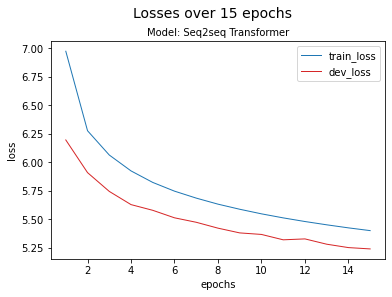

In [13]:
plot_over_training(plot_cache, 'Losses over 15 epochs', 'Model: Seq2seq Transformer', 15)